# EDA PROYECTIA - ANÁLISIS POR CURSOS
# PASO 1: Setup inicial y funciones base

In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict, Counter
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("📚 EDA PROYECTIA - ANÁLISIS POR CURSOS")
print("=" * 50)
print(f"🕒 Iniciado: {datetime.now().strftime('%d/%m/%Y %H:%M')}")
print("🎯 Objetivo: Análisis paso a paso de perfiles por curso")

📚 EDA PROYECTIA - ANÁLISIS POR CURSOS
🕒 Iniciado: 12/07/2025 11:45
🎯 Objetivo: Análisis paso a paso de perfiles por curso


# Funciones base para cargar y explorar datos


In [6]:
def listar_archivos_curso():
    """Lista todos los archivos de curso disponibles"""
    carpeta = '../data/processed/por_curso'
    
    if not os.path.exists(carpeta):
        print(f"❌ No se encuentra la carpeta: {carpeta}")
        return []
    
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.json')]
    archivos_ordenados = sorted(archivos)
    
    print(f"\n📁 ARCHIVOS DISPONIBLES EN {carpeta}:")
    print("-" * 40)
    
    for i, archivo in enumerate(archivos_ordenados, 1):
        print(f"{i}. {archivo}")
    
    return archivos_ordenados

def cargar_curso(nombre_archivo):
    """
    Carga un archivo de curso específico
    Retorna: datos_curso, metadata, perfiles
    """
    ruta_completa = f'../data/processed/por_curso/{nombre_archivo}'
    
    if not os.path.exists(ruta_completa):
        print(f"❌ No se encuentra el archivo: {ruta_completa}")
        return None, None, None
    
    try:
        with open(ruta_completa, 'r', encoding='utf-8') as f:
            datos = json.load(f)
        
        metadata = datos.get('metadata', {})
        perfiles = datos.get('perfiles', [])
        curriculo_ref = datos.get('curriculo_referencia', {})
        
        print(f"\n✅ CARGADO: {nombre_archivo}")
        print(f"📊 Perfiles encontrados: {len(perfiles)}")
        print(f"📋 Curso: {metadata.get('curso', 'N/A')}")
        print(f"🎯 Materias en currículo: {list(curriculo_ref.keys())}")
        
        return datos, metadata, perfiles
        
    except Exception as e:
        print(f"❌ Error cargando {nombre_archivo}: {e}")
        return None, None, None

def explorar_estructura_perfil(perfil, mostrar_detalle=False):
    """Explora la estructura de un perfil individual"""
    
    print(f"\n🔍 ESTRUCTURA PERFIL: {perfil.get('identificacion', {}).get('id_perfil', 'SIN_ID')}")
    print("-" * 30)
    
    # Secciones principales
    secciones = list(perfil.keys())
    print(f"📋 Secciones encontradas: {secciones}")
    
    if mostrar_detalle:
        for seccion in secciones:
            if isinstance(perfil[seccion], dict):
                print(f"\n🔹 {seccion}:")
                if seccion == "estado_curricular":
                    # Especial para estado curricular
                    for materia, items in perfil[seccion].items():
                        print(f"   📚 {materia}: {len(items)} ítems")
                else:
                    print(f"   └── {len(perfil[seccion])} campos")
    
    return secciones

def resumen_tipos_estudiantes(perfiles):
    """Analiza distribución de tipos de estudiantes"""
    
    tipos = [p.get('identificacion', {}).get('tipo_estudiante', 'desconocido') 
             for p in perfiles]
    
    contador_tipos = Counter(tipos)
    
    print(f"\n👥 DISTRIBUCIÓN TIPOS DE ESTUDIANTES:")
    print("-" * 30)
    
    total = len(perfiles)
    for tipo, cantidad in contador_tipos.most_common():
        porcentaje = (cantidad / total) * 100
        print(f"🎯 {tipo}: {cantidad} ({porcentaje:.1f}%)")
    
    return contador_tipos

def resumen_estado_curricular(perfiles, curso_nombre):
    """Analiza el estado curricular del curso"""
    
    print(f"\n📋 ESTADO CURRICULAR - {curso_nombre.upper()}")
    print("-" * 40)
    
    # Recopilar todos los datos curriculares
    datos_curriculares = []
    
    for perfil in perfiles:
        estado_curr = perfil.get('estado_curricular', {})
        if not estado_curr:
            continue
            
        for materia, items in estado_curr.items():
            for item, datos in items.items():
                datos_curriculares.append({
                    'materia': materia,
                    'item': item,
                    'estado': datos.get('estado', ''),
                    'nivel_numerico': datos.get('nivel_numerico', 0),
                    'necesita_refuerzo': datos.get('necesita_refuerzo', False)
                })
    
    if not datos_curriculares:
        print("⚠️  No se encontraron datos de estado curricular")
        return None
    
    df_curricular = pd.DataFrame(datos_curriculares)
    
    # Estadísticas por materia
    print("📊 PROGRESO POR MATERIA:")
    for materia in df_curricular['materia'].unique():
        subset = df_curricular[df_curricular['materia'] == materia]
        progreso_medio = subset['nivel_numerico'].mean()
        items_refuerzo = subset['necesita_refuerzo'].sum()
        
        print(f"   📚 {materia}:")
        print(f"      ├── Progreso medio: {progreso_medio:.2f}/4")
        print(f"      └── Items que necesitan refuerzo: {items_refuerzo}")
    
    # Estadísticas generales
    estados_conteo = df_curricular['estado'].value_counts()
    print(f"\n📈 DISTRIBUCIÓN ESTADOS:")
    for estado, cantidad in estados_conteo.items():
        porcentaje = (cantidad / len(df_curricular)) * 100
        print(f"   🔸 {estado}: {cantidad} ({porcentaje:.1f}%)")
    
    return df_curricular

# ESTRUCTURAS PARA ACUMULAR DATOS DE MÚLTIPLES CURSOS

In [7]:
# Diccionario para almacenar datos de todos los cursos
datos_todos_cursos = {}
metadatos_cursos = {}
perfiles_acumulados = []

print(f"\n🔧 FUNCIONES BASE CARGADAS")
print("📋 Funciones disponibles:")
print("   ├── listar_archivos_curso()")
print("   ├── cargar_curso(nombre_archivo)")
print("   ├── explorar_estructura_perfil(perfil, mostrar_detalle=False)")
print("   ├── resumen_tipos_estudiantes(perfiles)")
print("   └── resumen_estado_curricular(perfiles, curso_nombre)")

print(f"\n🏗️  Estructuras de datos preparadas:")
print("   ├── datos_todos_cursos = {} (para acumular datos)")
print("   ├── metadatos_cursos = {} (metadata por curso)")
print("   └── perfiles_acumulados = [] (todos los perfiles)")

print(f"\n🚀 LISTO PARA EMPEZAR")
print("=" * 50)


🔧 FUNCIONES BASE CARGADAS
📋 Funciones disponibles:
   ├── listar_archivos_curso()
   ├── cargar_curso(nombre_archivo)
   ├── explorar_estructura_perfil(perfil, mostrar_detalle=False)
   ├── resumen_tipos_estudiantes(perfiles)
   └── resumen_estado_curricular(perfiles, curso_nombre)

🏗️  Estructuras de datos preparadas:
   ├── datos_todos_cursos = {} (para acumular datos)
   ├── metadatos_cursos = {} (metadata por curso)
   └── perfiles_acumulados = [] (todos los perfiles)

🚀 LISTO PARA EMPEZAR


# PASO 2: CARGAR LOS CURSOS

In [8]:
print("📚 PASO 3: CARGA MASIVA DE TODOS LOS CURSOS")
print("=" * 50)

# Reiniciar estructuras para carga limpia
datos_todos_cursos = {}
metadatos_cursos = {}
perfiles_acumulados = []

# Obtener todos los archivos
archivos_disponibles = listar_archivos_curso()

if not archivos_disponibles:
    print("❌ No se encontraron archivos de curso")
else:
    print(f"🎯 CARGANDO {len(archivos_disponibles)} CURSOS...")
    
    # Cargar todos los cursos
    for i, archivo in enumerate(archivos_disponibles, 1):
        print(f"\n📖 [{i}/{len(archivos_disponibles)}] Cargando {archivo}...")
        
        datos_curso, metadata, perfiles = cargar_curso(archivo)
        
        if datos_curso and perfiles:
            curso_nombre = metadata.get('curso', f'curso_{i}')
            
            # Guardar en estructuras acumulativas
            datos_todos_cursos[curso_nombre] = datos_curso
            metadatos_cursos[curso_nombre] = metadata
            perfiles_acumulados.extend(perfiles)
            
            print(f"   ✅ {curso_nombre}: {len(perfiles)} perfiles cargados")
            
        else:
            print(f"   ❌ Error cargando {archivo}")

📚 PASO 3: CARGA MASIVA DE TODOS LOS CURSOS

📁 ARCHIVOS DISPONIBLES EN ../data/processed/por_curso:
----------------------------------------
1. perfiles_1_primaria.json
2. perfiles_2_primaria.json
3. perfiles_3_primaria.json
4. perfiles_4_primaria.json
5. perfiles_5_primaria.json
6. perfiles_6_primaria.json
🎯 CARGANDO 6 CURSOS...

📖 [1/6] Cargando perfiles_1_primaria.json...

✅ CARGADO: perfiles_1_primaria.json
📊 Perfiles encontrados: 46
📋 Curso: 1_primaria
🎯 Materias en currículo: ['matematicas', 'lengua', 'ciencias']
   ✅ 1_primaria: 46 perfiles cargados

📖 [2/6] Cargando perfiles_2_primaria.json...

✅ CARGADO: perfiles_2_primaria.json
📊 Perfiles encontrados: 47
📋 Curso: 2_primaria
🎯 Materias en currículo: ['matematicas', 'lengua', 'ciencias']
   ✅ 2_primaria: 47 perfiles cargados

📖 [3/6] Cargando perfiles_3_primaria.json...

✅ CARGADO: perfiles_3_primaria.json
📊 Perfiles encontrados: 64
📋 Curso: 3_primaria
🎯 Materias en currículo: ['matematicas', 'lengua', 'ciencias']
   ✅ 3_primari

# ANÁLISIS CURRICULAR PROFUNDO

In [9]:
print("📋 ANÁLISIS CURRICULAR PROFUNDO - TODOS LOS CURSOS")
print("=" * 60)

# Extraer datos curriculares de todos los perfiles
datos_curriculares_completos = []

for perfil in perfiles_acumulados:
    curso = perfil.get('identificacion', {}).get('curso', 'desconocido')
    tipo_estudiante = perfil.get('identificacion', {}).get('tipo_estudiante', 'desconocido')
    id_perfil = perfil.get('identificacion', {}).get('id_perfil', 'sin_id')
    
    estado_curricular = perfil.get('estado_curricular', {})
    
    for materia, items in estado_curricular.items():
        for item, datos in items.items():
            registro = {
                'id_perfil': id_perfil,
                'curso': curso,
                'tipo_estudiante': tipo_estudiante,
                'materia': materia,
                'item_curricular': item,
                'estado': datos.get('estado', ''),
                'nivel_numerico': datos.get('nivel_numerico', 0),
                'necesita_refuerzo': datos.get('necesita_refuerzo', False),
                'puede_avanzar': datos.get('puede_avanzar', False),
                'descripcion': datos.get('descripcion', '')
            }
            datos_curriculares_completos.append(registro)

# Crear DataFrame curricular
df_curricular = pd.DataFrame(datos_curriculares_completos)

print(f"📊 DATOS CURRICULARES EXTRAÍDOS:")
print(f"   ├── Total registros curriculares: {len(df_curricular)}")
print(f"   ├── Estudiantes únicos: {df_curricular['id_perfil'].nunique()}")
print(f"   ├── Cursos: {df_curricular['curso'].nunique()}")
print(f"   ├── Materias: {df_curricular['materia'].nunique()}")
print(f"   └── Ítems curriculares únicos: {df_curricular['item_curricular'].nunique()}")

📋 ANÁLISIS CURRICULAR PROFUNDO - TODOS LOS CURSOS
📊 DATOS CURRICULARES EXTRAÍDOS:
   ├── Total registros curriculares: 8994
   ├── Estudiantes únicos: 26
   ├── Cursos: 6
   ├── Materias: 3
   └── Ítems curriculares únicos: 137


# PROGRESO CURRICULAR POR CURSO


📈 ANÁLISIS 1: PROGRESO CURRICULAR POR CURSO
--------------------------------------------------
📊 PROGRESO PROMEDIO POR CURSO Y MATERIA:

🎯 1_PRIMARIA:
   📚 ciencias: 2.63±1.05 (n=276)
   📚 lengua: 2.81±1.03 (n=368)
   📚 matematicas: 3.09±1.01 (n=368)

🎯 2_PRIMARIA:
   📚 ciencias: 3.05±0.95 (n=282)
   📚 lengua: 2.96±0.95 (n=376)
   📚 matematicas: 3.06±1.10 (n=470)

🎯 3_PRIMARIA:
   📚 ciencias: 2.96±1.00 (n=384)
   📚 lengua: 2.96±1.02 (n=512)
   📚 matematicas: 3.50±0.89 (n=576)

🎯 4_PRIMARIA:
   📚 ciencias: 2.91±1.01 (n=498)
   📚 lengua: 2.74±1.10 (n=664)
   📚 matematicas: 3.30±0.98 (n=747)

🎯 5_PRIMARIA:
   📚 ciencias: 2.88±1.00 (n=510)
   📚 lengua: 3.02±0.96 (n=680)
   📚 matematicas: 3.33±0.94 (n=765)

🎯 6_PRIMARIA:
   📚 ciencias: 2.98±0.95 (n=414)
   📚 lengua: 2.99±0.97 (n=552)
   📚 matematicas: 3.31±0.97 (n=552)


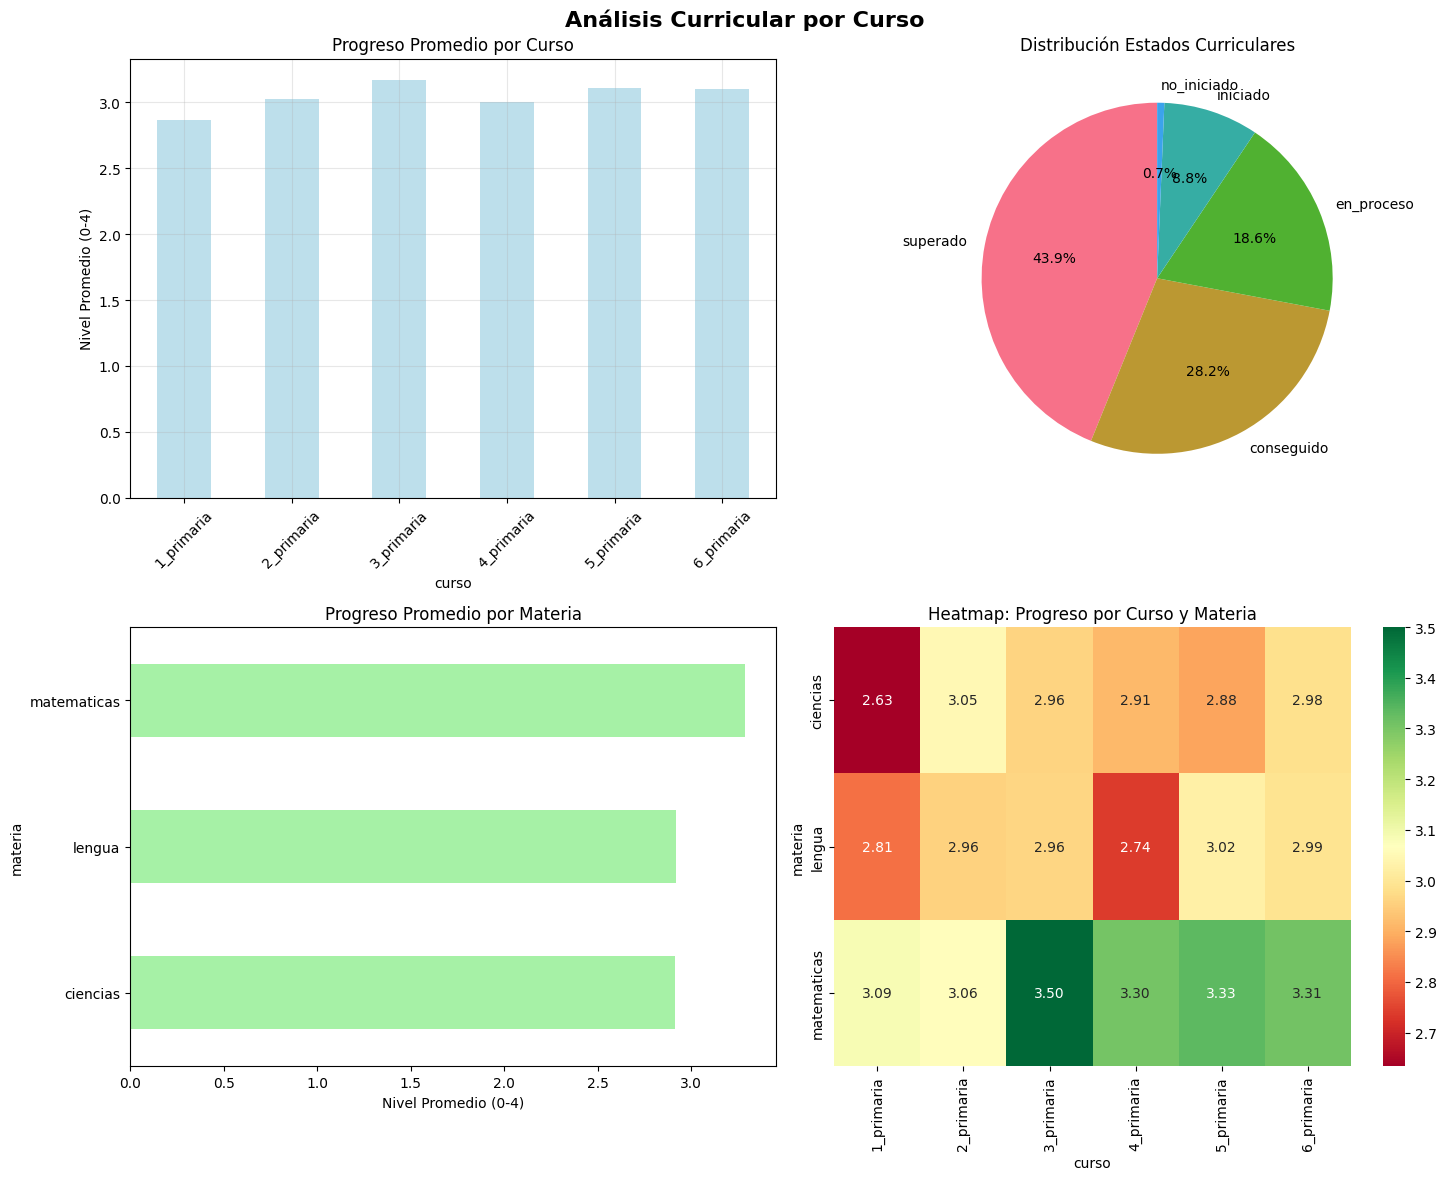

In [10]:
print(f"\n📈 ANÁLISIS 1: PROGRESO CURRICULAR POR CURSO")
print("-" * 50)

# Progreso promedio por curso y materia
progreso_curso_materia = df_curricular.groupby(['curso', 'materia'])['nivel_numerico'].agg(['mean', 'std', 'count']).round(2)

print("📊 PROGRESO PROMEDIO POR CURSO Y MATERIA:")
for curso in sorted(df_curricular['curso'].unique()):
    print(f"\n🎯 {curso.upper()}:")
    subset = progreso_curso_materia.loc[curso]
    for materia in subset.index:
        media = subset.loc[materia, 'mean']
        std = subset.loc[materia, 'std']
        count = subset.loc[materia, 'count']
        print(f"   📚 {materia}: {media:.2f}±{std:.2f} (n={count})")

# Visualización progreso por curso
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis Curricular por Curso', fontsize=16, fontweight='bold')

# Gráfico 1: Progreso promedio por curso
progreso_curso = df_curricular.groupby('curso')['nivel_numerico'].mean().sort_index()
progreso_curso.plot(kind='bar', ax=axes[0,0], color='lightblue', alpha=0.8)
axes[0,0].set_title('Progreso Promedio por Curso')
axes[0,0].set_ylabel('Nivel Promedio (0-4)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Gráfico 2: Distribución de estados curriculares
estados_counts = df_curricular['estado'].value_counts()
axes[0,1].pie(estados_counts.values, labels=estados_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Distribución Estados Curriculares')

# Gráfico 3: Progreso por materia (todas las materias)
progreso_materia = df_curricular.groupby('materia')['nivel_numerico'].mean().sort_values(ascending=True)
progreso_materia.plot(kind='barh', ax=axes[1,0], color='lightgreen', alpha=0.8)
axes[1,0].set_title('Progreso Promedio por Materia')
axes[1,0].set_xlabel('Nivel Promedio (0-4)')

# Gráfico 4: Heatmap curso x materia
pivot_progreso = df_curricular.pivot_table(values='nivel_numerico', index='materia', columns='curso', aggfunc='mean')
sns.heatmap(pivot_progreso, annot=True, cmap='RdYlGn', ax=axes[1,1], fmt='.2f')
axes[1,1].set_title('Heatmap: Progreso por Curso y Materia')

plt.tight_layout()
plt.show()
